# [通し課題]

8. DAY2、3で学んだことの取り組み • 交差検証、ホールドアウト法などで汎化性能を確認する  
 • 欠測値と異常値を確認し、適切に処理する  
 • DAY2、3で学んだアルゴリズムを利用してモデルをつくり、DAY1宿題提出時の精度と比較する  
 • 交差検証によるパラメータチューニングを行う  
 • パラメータチューニング後のモデルによって、精度および結果の評価を行う  
 • その他、精度の向上ができるような処理に取り組み、精度を上げる  
 • できたところまでをNotebookでまとめ、宿題として提出する  
 • 前回から取り組んだ内容・工夫、精度がどのように変化したかのコメントを Notebookに含めること  
 • 15分程度，受講者同士で通し課題の進捗を見せ合う時間を設けます  
9. DAY4では、DAY3宿題の提出ファイルを元に、最終発表を実施いただ

# 0. DAY1~２での実施事項


In [1]:
#********************************************************************
# pandas,numpy,matplotlib,codecs,sklearnの各ライブラリをインポート
#********************************************************************

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import codecs as cd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import seaborn as sns

#********************************************************************
#.該当課題のデータを読み込む
#********************************************************************
#201801のデータを読み込んでみる
with cd.open('ks-projects-201801.csv', 'r', 'utf-8', 'ignore') as f18:
    df_f18 = pd.read_csv(f18)
#df_f18 = pd.read_csv('ks-projects-201801.csv')

#********************************************************************
#.欠損値がある行は、とりあえずなくしてみる
#********************************************************************
#１個でも欠損値がある行はとりあえず削除してみる。
df_f18_dna = df_f18.dropna(how='any')

#********************************************************************
#.成功（'successful'）と失敗（'failed'）に絞って考える。
#********************************************************************
#成功だけを抽出したDFと失敗だけを抽出したDF
df_f18_success = df_f18_dna[df_f18_dna['state']=='successful']
df_f18_failed =  df_f18_dna[df_f18_dna['state']=='failed']
#両方を結合
df_f18_SorF = pd.concat([df_f18_success,df_f18_failed])

#********************************************************************
#.'state'をカテゴリ変数（文字列）から数値化してみる。
#********************************************************************
#LabelEncoderのインスタンスを生成
le = LabelEncoder()

#stateに出てくるカテゴリを覚えて
#stateを数値に変換
le = le.fit(df_f18_SorF['state'])
df_f18_SorF['state'] = le.transform(df_f18_SorF['state'])

#********************************************************************
#.'deadline' 'launched' の項目から期間'days'を日数で割り出す
#********************************************************************
# 'deadline' 'launched' の項目をdatetimeに変更
df_f18_SorF['deadline'] = pd.to_datetime(df_f18_SorF['deadline'], errors = 'coerce')
df_f18_SorF['launched'] = pd.to_datetime(df_f18_SorF['launched'], errors = 'coerce')
# 'deadline' 'launched' の間の日数を示す'period'を作成
df_f18_SorF['period'] = df_f18_SorF['deadline'] - df_f18_SorF['launched']

days = []

#'period'の日数を'days'に抽出
for i in df_f18_SorF.index:
    days.append(df_f18_SorF['period'][i].days)
#'days'列を追加
df_f18_SorF['days'] = days

#####################################
#異常値を除いたデータフレームを作る。
#####################################
#goalの異常値を除いたデータフレーム
df_train = df_f18_SorF[df_f18_SorF['goal']<99999999]

#####################################
#country,main_category,categoryをOne-Hotに変換する。
#####################################
df_train = pd.get_dummies(df_train, columns=['country', 'category', 'main_category'])


In [13]:

#********************************************************************
#.ロジスティック回帰で分類してみる。
#********************************************************************

#目的変数'state'を正解としてyに格納
y = df_train['state'].values
#説明変数'goal','backers','days','country_GB','country_HK','country_SG','country_US','main_category_rate','category_rate'を入力としてXに格納
X = df_train[['goal','days','country_GB','country_HK','country_SG','country_US','main_category_Art',\
                  'main_category_Comics','main_category_Dance','main_category_Design','main_category_Film & Video',\
                  'main_category_Games','main_category_Music','main_category_Theater',\
                 'category_Anthologies','category_Chiptune','category_Classical Music','category_Comic Books','category_Country & Folk',\
                  'category_Dance','category_Indie Rock','category_Jazz','category_Letterpress','category_Performances','category_Plays',\
                  'category_Residencies','category_Tabletop Games','category_Theater','category_Typography']].values

#ロジスティック回帰で学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X, y)

#********************************************************************
#.予測精度または識別精度を確認する
#　混同行列を作成し、Accuracy、Recall、Precisionを求める
#********************************************************************
# 学習した結果を使って説明変数を入力して予測
y_est = clf.predict(X)

#混同行列を作成
tn, fp, fn, tp = confusion_matrix(y, y_est).ravel()
print(fn, fp)
print(tn, tp)

#'Accuracy、Recall、Precisionを求めて表示
print('Accuracy  = {:.3f}%'.format(100 * (tn+tp)/(tn+fp+fn+tp)))
print('Recall    = {:.3f}%'.format(100 * (tp)/(fn+tp)))
print('Precision = {:.3f}%'.format(100 * (tp)/(fp+tp)))

47591 29609
93594 36176
Accuracy  = 62.700%
Recall    = 43.186%
Precision = 54.991%


In [2]:
df_train.head()

,ID,name,currency,deadline,goal,launched,pledged,state,backers,usd pledged,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
5,1000014025,Monarch Espresso Bar,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224.0,52375.00,...,0,0,1,0,0,0,0,0,0,0
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.0,1,16.0,1205.00,...,0,0,1,0,0,0,0,0,0,0
11,100005484,Lisa Lim New CD!,USD,2013-04-08,12500.0,2013-03-09 06:42:58,12700.0,1,100.0,12700.00,...,0,0,0,0,0,1,0,0,0,0
14,1000057089,Tombstone: Old West tabletop game and miniatur...,GBP,2017-05-03,5000.0,2017-04-05 19:44:18,94175.0,1,761.0,57763.78,...,0,0,0,1,0,0,0,0,0,0
18,1000070642,Mike Corey's Darkness & Light Album,USD,2012-08-17,250.0,2012-08-02 14:11:32,250.0,1,7.0,250.00,...,0,0,0,0,0,1,0,0,0,0


# １．交差検証、ホールドアウト法などで汎化性能を確認する  

## 1.1. 欠測値と異常値を確認し、適切に処理する 

##  1.2. DAY2、3で学んだアルゴリズムを利用してモデルをつくり、DAY1宿題提出時の精度と比較する

### 1.3. 交差検証によるパラメータチューニングを行う

In [2]:
# ホールドアウト法に関する関数
from sklearn.model_selection import train_test_split
# 交差検証法に関する関数
from sklearn.model_selection import KFold
# 回帰問題における性能評価に関する関数
from sklearn.metrics import mean_absolute_error

ホールドアウト法で、最終的に性能を見るためのテストデータを別にする。（３０％をテストデータに）  

In [3]:
train_label = df_train['state']
train_data = df_train.drop(['state','name','currency','deadline','goal','launched','pledged','backers','usd pledged','usd_pledged_real','period'], axis=1)

#目的変数'state'を正解としてyに格納
y = train_label.values
#説明変数'goal','backers','days','country_rate','main_category_rate','category_rate'を入力としてXに格納
X = train_data.values
#X = df_train[['goal', 'backers','days','country_rate','main_category_rate','category_rate']].values

# 全データのうち、30%をテストデータにする
test_size = 0.3

# ホールドアウト法を実行（テストデータはランダム選択）
#X_train : 学習用データの説明変数
#X_test : テスト用データの説明変数
#y_train : 学習用データの目的変数
#y_test : テスト用データの目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(144879, 199) (62091, 199) (144879,) (62091,)


In [4]:
#現在の最大表示列数の出力
pd.get_option("display.max_columns")

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 1000)

display(df_train.head())

,ID,name,currency,deadline,goal,launched,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period,days,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Couture,category_Crafts,category_Crochet,category_DIY,category_DIY Electronics,category_Dance,category_Design,category_Digital Art,category_Documentary,category_Drama,category_Drinks,category_Electronic Music,category_Embroidery,category_Events,category_Experimental,category_Fabrication Tools,category_Faith,category_Family,category_Fantasy,category_Farmer's Markets,category_Farms,category_Fashion,category_Festivals,category_Fiction,category_Film & Video,category_Fine Art,category_Flight,category_Food,category_Food Trucks,category_Footwear,category_Gadgets,category_Games,category_Gaming Hardware,category_Glass,category_Graphic Design,category_Graphic Novels,category_Hardware,category_Hip-Hop,category_Horror,category_Illustration,category_Immersive,category_Indie Rock,category_Installations,category_Interactive Design,category_Jazz,category_Jewelry,category_Journalism,category_Kids,category_Knitting,category_Latin,category_Letterpress,category_Literary Journals,category_Literary Spaces,category_Live Games,category_Makerspaces,category_Metal,category_Mixed Media,category_Mobile Games,category_Movie Theaters,category_Music,category_Music Videos,category_Musical,category_Narrative Film,category_Nature,category_Nonfiction,category_Painting,category_People,category_Performance Art,category_Performances,category_Periodicals,category_Pet Fashion,category_Photo,category_Photobooks,category_Photography,category_Places,category_Playing Cards,category_Plays,category_Poetry,category_Pop,category_Pottery,category_Print,category_Printing,category_Product Design,category_Public Art,category_Publishing,category_Punk,category_Puzzles,category_Quilts,category_R&B,category_Radio & Podcasts,category_Ready-to-wear,category_Residencies,category_Restaurants,category_Robots,category_Rock,category_Romance,category_Science Fiction,category_Sculpture,category_Shorts,category_Small Batch,category_Software,category_Sound,category_Space Exploration,category_Spaces,category_Stationery,category_Tabletop Games,category_Taxidermy,category_Technology,category_Television,category_Textiles,category_Theater,category_Thrillers,category_Translations,category_Typography,category_Vegan,category_Video,category_Video Art,category_Video Games,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
5,1000014025,Monarch Espresso Bar,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224.0,52375.00,52375.00,50000.00,34 days 10:21:33,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

## 特長量を選択する（埋め込み法）

In [5]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True,max_iter=10000,cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [6]:
# fitで特徴選択を実行
sfm.fit(X_train, y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
        norm_order=1, prefit=False, threshold=1e-05)

In [7]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([False, False,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [8]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
train_data.columns[removed_idx]

Index(['ID', 'usd_goal_real', 'country_CA', 'country_CH',
       'category_Children's Books', 'category_Comics', 'category_Crafts',
       'category_Design', 'category_Fabrication Tools', 'category_Fashion',
       'category_Food', 'category_Glass', 'category_Graphic Design',
       'category_Literary Spaces', 'category_Music', 'category_Photography',
       'category_Poetry', 'category_Pop', 'category_Romance',
       'category_Taxidermy', 'category_Woodworking', 'category_World Music',
       'main_category_Art', 'main_category_Film & Video',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Publishing'],
      dtype='object')

### ここで、'usd_goal_real'が削除すべき特徴量として選択される。
### 実質、期間'days'、国'country'、カテゴリ'category','main_category'で分類することになる。

In [9]:
# LASSOで得た各特徴の係数の値を確認してみる
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([0.00000000e+00, 1.32239957e-08, 4.24511561e-03, 6.93793351e-02,
       1.59219971e-02, 1.11040276e-02, 0.00000000e+00, 0.00000000e+00,
       3.10667629e-02, 3.72427634e-02, 4.81265951e-02, 4.89797886e-02,
       3.71570008e-02, 1.23931524e-01, 2.78080562e-02, 1.16841264e-01,
       1.17232234e-01, 2.06195820e-02, 5.67020609e-02, 5.70695289e-02,
       1.32841755e-03, 1.64407472e-03, 2.00717504e-02, 6.97197684e-02,
       5.06327238e-02, 6.01168790e-02, 1.21065640e-01, 6.47141820e-02,
       1.48809071e-01, 1.12968886e-01, 7.80990456e-02, 2.17320379e-01,
       4.50204475e-02, 2.31789782e-01, 8.90086182e-02, 5.81722166e-02,
       1.67372150e-01, 7.87470858e-02, 5.06202075e-02, 4.93609631e-02,
       2.37819731e-02, 2.16289637e-01, 1.10915151e-01, 7.39201246e-02,
       0.00000000e+00, 5.56379677e-02, 2.78566157e-01, 1.32434582e-02,
       1.72531489e-01, 1.94255234e-02, 8.89887191e-02, 0.00000000e+00,
       7.28774102e-02, 1.98593784e-02, 4.03445123e-02, 1.50190573e-01,
      

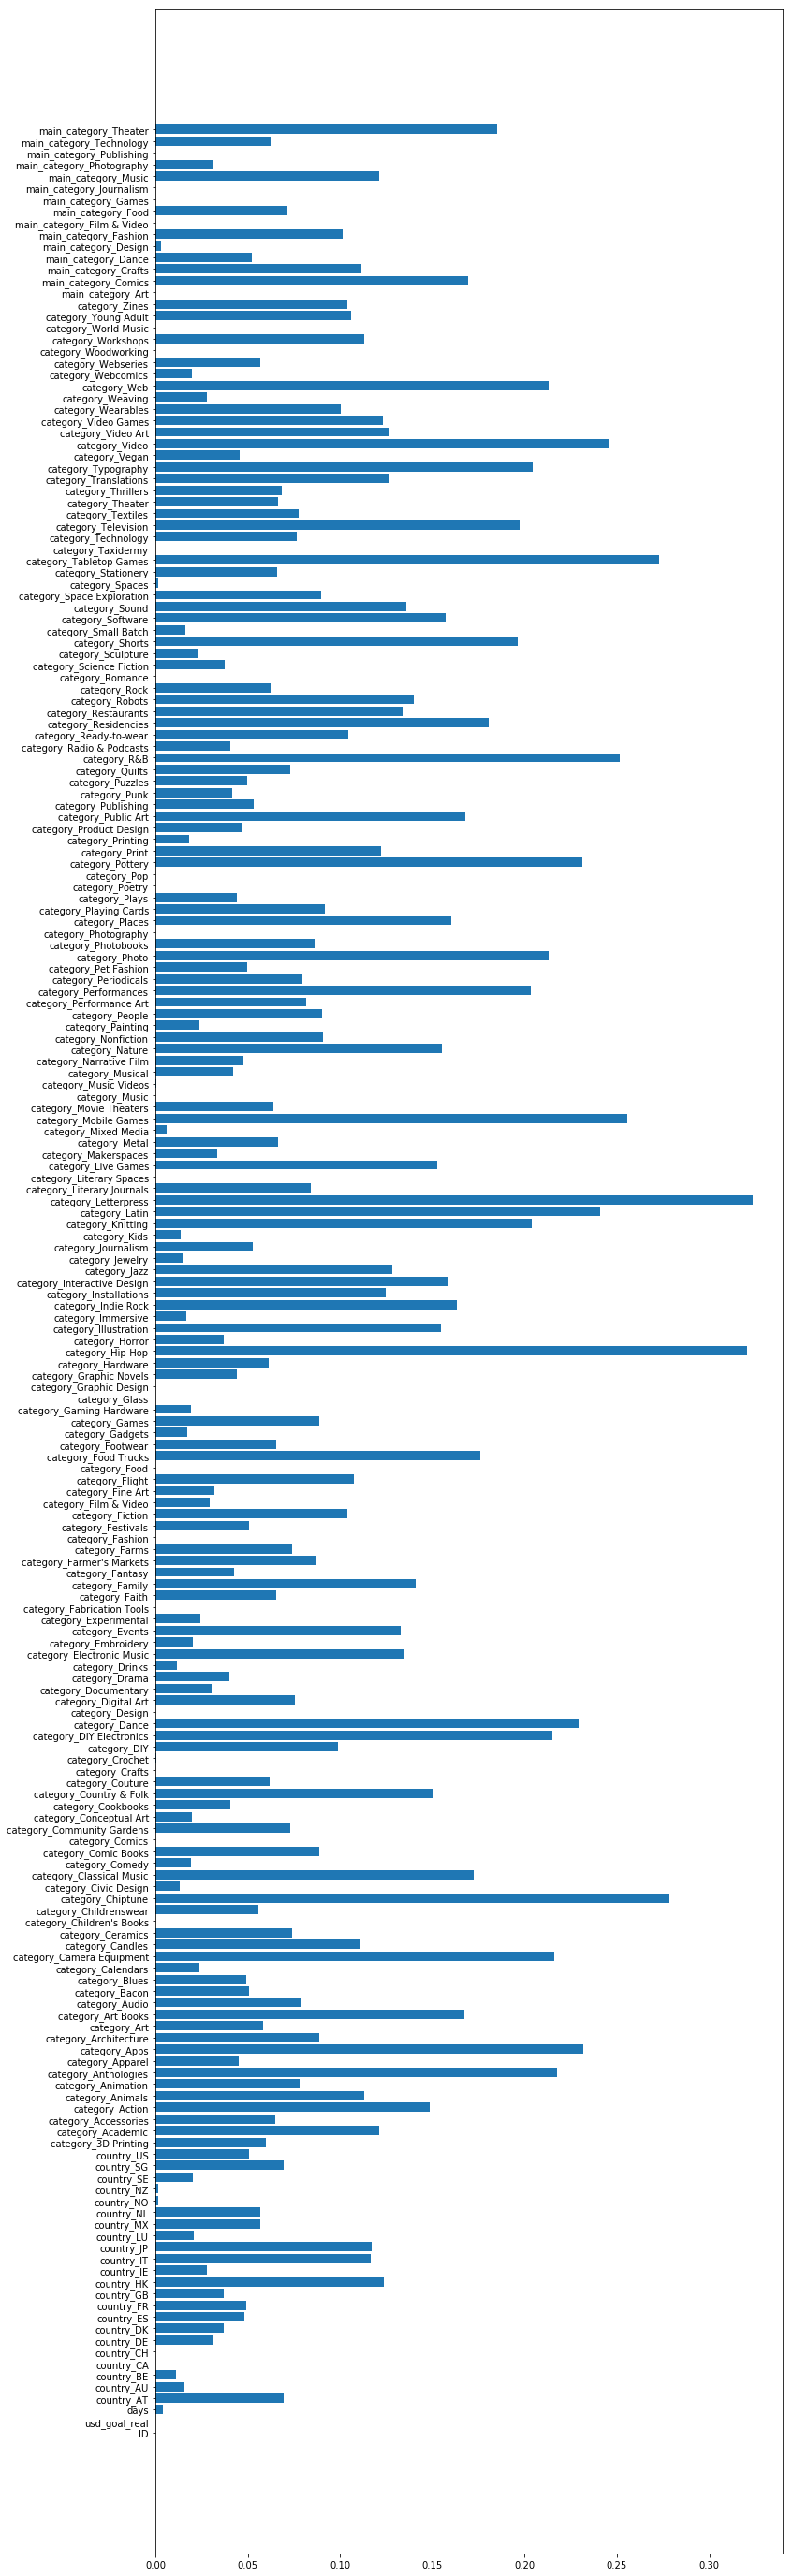

In [10]:
# 係数を棒グラフで表示
fig = plt.figure(figsize=(12, 50)) 
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=train_data.columns.values)
plt.show()

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import display
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.metrics import confusion_matrix

### 削除すべき特徴量を削除して、改めて３割をテストデータ、７割を訓練データに分割する。

In [12]:
#　ラベルデータとして’state’を作成
train_label = df_train['state']

#　Leakageになりそうなカラム、相関が強いカラムをドロップする
train_data = df_train.drop(['state','name','currency','deadline','goal','launched','pledged','backers','usd pledged','usd_pledged_real','period'], axis=1)
#　Lassoで削除するべき特徴量に選ばれたカラムをドロップする
train_data = train_data.drop(train_data.columns[removed_idx], axis=1)

#目的変数'state'を正解としてyに格納
y = train_label.values
#カラムをドロップした説明変数を、Xに格納
X = train_data.values

# 全データのうち、30%をテストデータにする
test_size = 0.3

# ホールドアウト法を実行（テストデータはランダム選択）
#X_train : 学習用データの説明変数
#X_test : テスト用データの説明変数
#y_train : 学習用データの目的変数
#y_test : テスト用データの目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,shuffle=True, random_state=1234) 

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(144879, 172) (62091, 172) (144879,) (62091,)


### 1,2層目tanh 3,4層目ReLU、5層目Sigmoid の２値分類NN, 　間にバッチ正規化の処理を入れる。
### 最適化手法にはAdamを採用し学習率を変化させて、テストデータAccuracyが最大になる値を探す。
### 探すにあたっては、交差検証法を利用する。  
パラメータチューニングには３分割で交差検証を行う。

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
#Lassoで削除された説明変数を削除する場合
model.add(Dense(256, activation='tanh', input_dim=172))
model.add(BatchNormalization())
model.add(Dense(256, activation='tanh'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [53]:
#学習率毎のAccuracy格納用データフレームを初期化
df_lr_Acc = pd.DataFrame(index=[], columns=['lr','step','loss', 'val_loss','acc', 'val_acc'])
for lr in np.arange(0.001,0.01,0.001):
    #クロスバリデーションの検証毎のAccuracy格納用データフレームを初期化
    df_val_Acc = pd.DataFrame(index=[], columns=['step','loss', 'val_loss','acc', 'val_acc'])
    #クロスバリデーションでの検証ステップを初期化
    step = 1
    #クロスバリデーションで検証
    for train_index, test_index in KFold(n_splits=3,shuffle=True, random_state=1234).split(X_train, y_train):
        X_val_train, X_val_test = X[train_index], X[test_index]
        y_val_train, y_val_test = y[train_index], y[test_index]
        print(X_val_train.shape, X_val_test.shape,y_val_train.shape, y_val_test.shape)
        
        # ------ 最適化手法 ------
        adam = Adam(lr=lr)
        # -----------------------------

        model.compile(loss='binary_crossentropy',
                      optimizer=adam,
                      metrics=['accuracy'])
    
        # 計算の実行
        fit = model.fit(X_val_train, y_val_train,epochs=5,batch_size=256,validation_data=(X_val_test, y_val_test))

        # 各epochにおける損失と精度をdfに入れる
        df = pd.DataFrame(fit.history)
        
        val_df = pd.DataFrame(index=[],columns=['step','loss', 'val_loss','acc', 'val_acc'])
        val_df = val_df.append(df,ignore_index = True,sort=False)
        val_df[['step']] = step
        
        df_val_Acc = df_val_Acc.append(val_df, ignore_index = True,sort=False) 
        step = step + 1

    lr_df = pd.DataFrame(index=[],columns=['lr','step','loss', 'val_loss','acc', 'val_acc'])
    lr_df = lr_df.append(df_val_Acc.mean(),ignore_index = True,sort=False)
    lr_df['lr'] = lr
    
    df_lr_Acc = df_lr_Acc.append(lr_df, ignore_index = True,sort=False)


(96586, 172) (48293, 172) (96586,) (48293,)
Train on 96586 samples, validate on 48293 samples
Epoch 1/5
96586/96586 [==============================] - 11s 113us/step - loss: 0.6329 - acc: 0.6415 - val_loss: 0.6412 - val_acc: 0.6264
Epoch 2/5
96586/96586 [==============================] - 9s 88us/step - loss: 0.6197 - acc: 0.6553 - val_loss: 0.6265 - val_acc: 0.6441
Epoch 3/5
96586/96586 [==============================] - 9s 89us/step - loss: 0.6178 - acc: 0.6564 - val_loss: 0.6372 - val_acc: 0.6317
Epoch 4/5
96586/96586 [==============================] - 9s 91us/step - loss: 0.6163 - acc: 0.6580 - val_loss: 0.6203 - val_acc: 0.6544
Epoch 5/5
96586/96586 [==============================] - 9s 95us/step - loss: 0.6154 - acc: 0.6593 - val_loss: 0.6229 - val_acc: 0.6493
(96586, 172) (48293, 172) (96586,) (48293,)
Train on 96586 samples, validate on 48293 samples
Epoch 1/5
96586/96586 [==============================] - 12s 122us/step - loss: 0.6180 - acc: 0.6543 - val_loss: 0.6353 - val_acc:

Epoch 3/5
96586/96586 [==============================] - 12s 123us/step - loss: 0.6117 - acc: 0.6617 - val_loss: 0.6281 - val_acc: 0.6429
Epoch 4/5
96586/96586 [==============================] - 12s 128us/step - loss: 0.6103 - acc: 0.6631 - val_loss: 0.6180 - val_acc: 0.6575
Epoch 5/5
96586/96586 [==============================] - 12s 129us/step - loss: 0.6095 - acc: 0.6642 - val_loss: 0.6451 - val_acc: 0.6400
(96586, 172) (48293, 172) (96586,) (48293,)
Train on 96586 samples, validate on 48293 samples
Epoch 1/5
96586/96586 [==============================] - 17s 173us/step - loss: 0.6137 - acc: 0.6580 - val_loss: 0.6276 - val_acc: 0.6292
Epoch 2/5
96586/96586 [==============================] - 14s 148us/step - loss: 0.6130 - acc: 0.6586 - val_loss: 0.6124 - val_acc: 0.6616
Epoch 3/5
96586/96586 [==============================] - 14s 146us/step - loss: 0.6117 - acc: 0.6595 - val_loss: 0.6120 - val_acc: 0.6625
Epoch 4/5
96586/96586 [==============================] - 13s 132us/step - loss

In [55]:
display(df_lr_Acc)
#display(df_val_Acc)

,lr,step,loss,val_loss,acc,val_acc
0,0.001,2.0,0.616865,0.629140,0.656589,0.644717
1,0.002,2.0,0.614168,0.626992,0.659109,0.646534
2,0.003,2.0,0.612774,0.626886,0.660399,0.647079
3,0.004,2.0,0.611683,0.622813,0.661034,0.648478
4,0.005,2.0,0.610517,0.622491,0.662487,0.646077
5,0.006,2.0,0.610405,0.627468,0.662440,0.646147
6,0.007,2.0,0.611132,0.625084,0.661896,0.647473
7,0.008,2.0,0.612308,0.627778,0.660742,0.646867
8,0.009,2.0,0.616417,0.631615,0.656790,0.639158


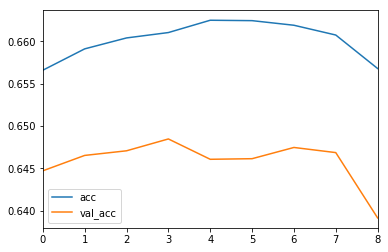

In [54]:
df_lr_Acc[['acc', 'val_acc']].plot()
plt.show()
#df_val_Acc[['acc', 'val_acc']].plot()
#plt.show()

### 1.4. パラメータチューニング後のモデルによって、精度および結果の評価を行う

#### 学習率が0.004のときにバリデーションでのAccuracyが約64.8%の最大値が出ているので、採用
#### 訓練データをすべて投入し、epoch数を増やしてみてテストデータでの精度を確認する。

Instructions for updating:
Use tf.cast instead.
Train on 144879 samples, validate on 62091 samples
Epoch 1/100
144879/144879 [==============================] - 12s 86us/step - loss: 0.6267 - acc: 0.6521 - val_loss: 0.6381 - val_acc: 0.6314
Epoch 2/100
144879/144879 [==============================] - 10s 67us/step - loss: 0.6162 - acc: 0.6602 - val_loss: 0.6633 - val_acc: 0.5817
Epoch 3/100
144879/144879 [==============================] - 10s 67us/step - loss: 0.6149 - acc: 0.6601 - val_loss: 0.6352 - val_acc: 0.6537
Epoch 4/100
144879/144879 [==============================] - 10s 67us/step - loss: 0.6142 - acc: 0.6622 - val_loss: 0.6180 - val_acc: 0.6589
Epoch 5/100
144879/144879 [==============================] - 10s 67us/step - loss: 0.6132 - acc: 0.6630 - val_loss: 0.9158 - val_acc: 0.4409
Epoch 6/100
144879/144879 [==============================] - 10s 67us/step - loss: 0.6129 - acc: 0.6634 - val_loss: 0.6263 - val_acc: 0.6427
Epoch 7/100
144879/144879 [============================

144879/144879 [==============================] - 10s 66us/step - loss: 0.5996 - acc: 0.6730 - val_loss: 0.6197 - val_acc: 0.6594
Epoch 57/100
144879/144879 [==============================] - 10s 67us/step - loss: 0.5997 - acc: 0.6731 - val_loss: 0.6435 - val_acc: 0.6299
Epoch 58/100
144879/144879 [==============================] - 10s 67us/step - loss: 0.5997 - acc: 0.6735 - val_loss: 0.6189 - val_acc: 0.6589
Epoch 59/100
144879/144879 [==============================] - 10s 67us/step - loss: 0.5999 - acc: 0.6737 - val_loss: 0.6199 - val_acc: 0.6594
Epoch 60/100
144879/144879 [==============================] - 10s 67us/step - loss: 0.5992 - acc: 0.6732 - val_loss: 0.6198 - val_acc: 0.6592
Epoch 61/100
144879/144879 [==============================] - 10s 67us/step - loss: 0.5992 - acc: 0.6733 - val_loss: 0.6181 - val_acc: 0.6597
Epoch 62/100
144879/144879 [==============================] - 10s 67us/step - loss: 0.5989 - acc: 0.6733 - val_loss: 0.6389 - val_acc: 0.6354
Epoch 63/100
144879

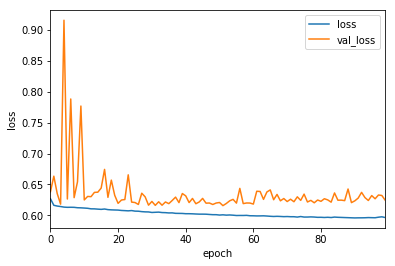

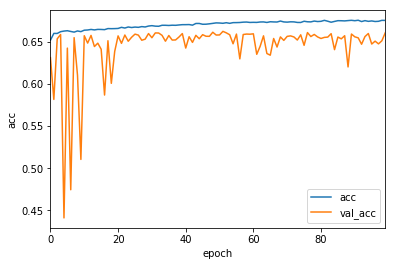

In [16]:
# ------ 最適化手法 ------
adam = Adam(lr=0.004)
# -----------------------------

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# 計算の実行
fit = model.fit(X_train, y_train,epochs=100,batch_size=256,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)
    
# グラフ化
df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

df[['acc', 'val_acc']].plot()
plt.ylabel('acc')
plt.xlabel('epoch')
#plt.ylim([0,1.0])
plt.show()


### エポック数を増やしても、66％以上、精度が上がらない。
### さらなる工夫が必要。

# 1.5. その他、精度の向上ができるような処理に取り組み、精度を上げる

## AdaBoostでも試してみる。

### Lassoの特徴量削減は行わず、改めて３割をテストデータ、７割を訓練データに分割する。

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#　ラベルデータとして’state’を作成
adB_train_label = df_train['state']

#　Leakageになりそうなカラム、相関が強いカラムをドロップする
adB_train_data = df_train.drop(['state','name','currency','deadline','goal','launched','pledged','backers','usd pledged','usd_pledged_real','period'], axis=1)

#目的変数'state'を正解としてyに格納
adB_y = adB_train_label.values
#カラムをドロップした説明変数を、Xに格納
adB_X = adB_train_data.values

# 全データのうち、30%をテストデータにする
test_size = 0.3

# ホールドアウト法を実行（テストデータはランダム選択）
#X_train : 学習用データの説明変数
#X_test : テスト用データの説明変数
#y_train : 学習用データの目的変数
#y_test : テスト用データの目的変数
adB_X_train, adB_X_test, adB_y_train, adB_y_test = train_test_split(adB_X, adB_y, test_size=test_size,shuffle=True, random_state=1234) 

print(adB_X_train.shape, adB_X_test.shape, adB_y_train.shape, adB_y_test.shape)

(144879, 199) (62091, 199) (144879,) (62091,)


### max_depthを変化させて、Accuracyが最大になる値を探す。
### 探すにあたっては、交差検証法を利用する。  

In [42]:
#毎のAccuracy格納用データフレームを初期化
df_md_Acc = pd.DataFrame(index=[], columns=['max_depth','val_acc'])
for max_depth in np.arange(3,10,1):
    #クロスバリデーションの検証毎のAccuracy格納用データフレームを初期化
    df_val_Acc = pd.DataFrame(index=[], columns=['val_acc'])
    #クロスバリデーションでの検証ステップを初期化
    #クロスバリデーションで検証
    for train_index, test_index in KFold(n_splits=2,shuffle=True, random_state=1234).split(adB_X_train, adB_y_train):
        adB_X_val_train, adB_X_val_test = adB_X[train_index], adB_X[test_index]
        adB_y_val_train, adB_y_val_test = adB_y[train_index], adB_y[test_index]
        #print(adB_X_val_train.shape, adB_X_val_test.shape,adB_y_val_train.shape, adB_y_val_test.shape)

        clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,min_samples_split=2,random_state=1234,criterion="gini"),
                                           n_estimators=10, random_state=1234)
        clf.fit(adB_X_val_train, adB_y_val_train)
        score = clf.score(adB_X_val_test, adB_y_val_test)
        print("max_depth=",max_depth)
        print("score=", score)
        
        val_se = pd.Series( [score], index=df_val_Acc.columns )
        
        df_val_Acc = df_val_Acc.append(val_se, ignore_index = True,sort=False) 
 
    md_df = pd.DataFrame(index=[],columns=['max_depth','val_acc'])
    md_df = md_df.append(df_val_Acc.mean(),ignore_index = True,sort=False)
    md_df['max_depth'] = max_depth
    
    df_md_Acc = df_md_Acc.append(md_df, ignore_index = True,sort=False)

max_depth= 3
score= 0.7639425731639978
max_depth= 3
score= 0.7657615372934469
max_depth= 4
score= 0.7642186637217007
max_depth= 4
score= 0.7667968911774045
max_depth= 5
score= 0.7650193263390392
max_depth= 5
score= 0.7665346015268019
max_depth= 6
score= 0.7642876863611264
max_depth= 6
score= 0.7646157456618672
max_depth= 7
score= 0.7637078961899503
max_depth= 7
score= 0.7631662502243267
max_depth= 8
score= 0.7614991717283269
max_depth= 8
score= 0.7623103576802551
max_depth= 9
score= 0.7586002208724462
max_depth= 9
score= 0.7589282016593272


,max_depth,val_acc
0,3,0.764852
1,4,0.765508
2,5,0.765777
3,6,0.764452
4,7,0.763437
5,8,0.761905
6,9,0.758764


,val_acc
0,0.758600
1,0.758928


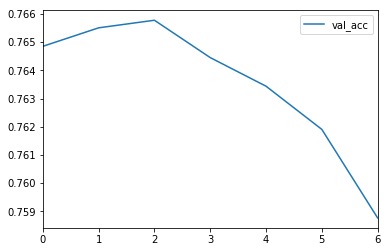

In [45]:
display(df_md_Acc)
display(df_val_Acc)
df_md_Acc[['val_acc']].plot()
plt.show()

#### max_depthが4のときにバリデーションでのAccuracyが約76.5%の最大値が出ているので、採用
#### 訓練データをすべて投入し、テストデータでの精度を確認する。

In [49]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4,min_samples_split=2,random_state=1234,criterion="gini"),
                                           n_estimators=10, random_state=1234)
clf.fit(adB_X_train, adB_y_train)
print("score=", clf.score(adB_X_test, adB_y_test))


score= 0.6743972556409141


### クロスバリデーション時よりは精度が下がったが、NNよりも精度があがった。

### 予測時に使われている説明変数を確認する。

[0.00942993 0.20151957 0.1678284  0.         0.         0.
 0.         0.         0.         0.         0.         0.00043845
 0.00908233 0.         0.         0.01692348 0.         0.
 0.00055108 0.         0.         0.         0.00055197 0.
 0.02077308 0.         0.         0.         0.         0.
 0.         0.00054818 0.         0.02186462 0.         0.
 0.01449446 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01564556 0.         0.         0.         0.         0.
 0.         0.01574113 0.         0.         0.         0.
 0.         0.         0.         0.         0.01390716 0.
 0.         0.01961432 0.         0.00042681 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.02072921 0.         0.         0.         0.
 0.02046626 0.00323692 0.         0.         0.         0.
 0.         0.         0.         0.02223817 0.         0.01080614
 0.         0.01313222 0.         0.    

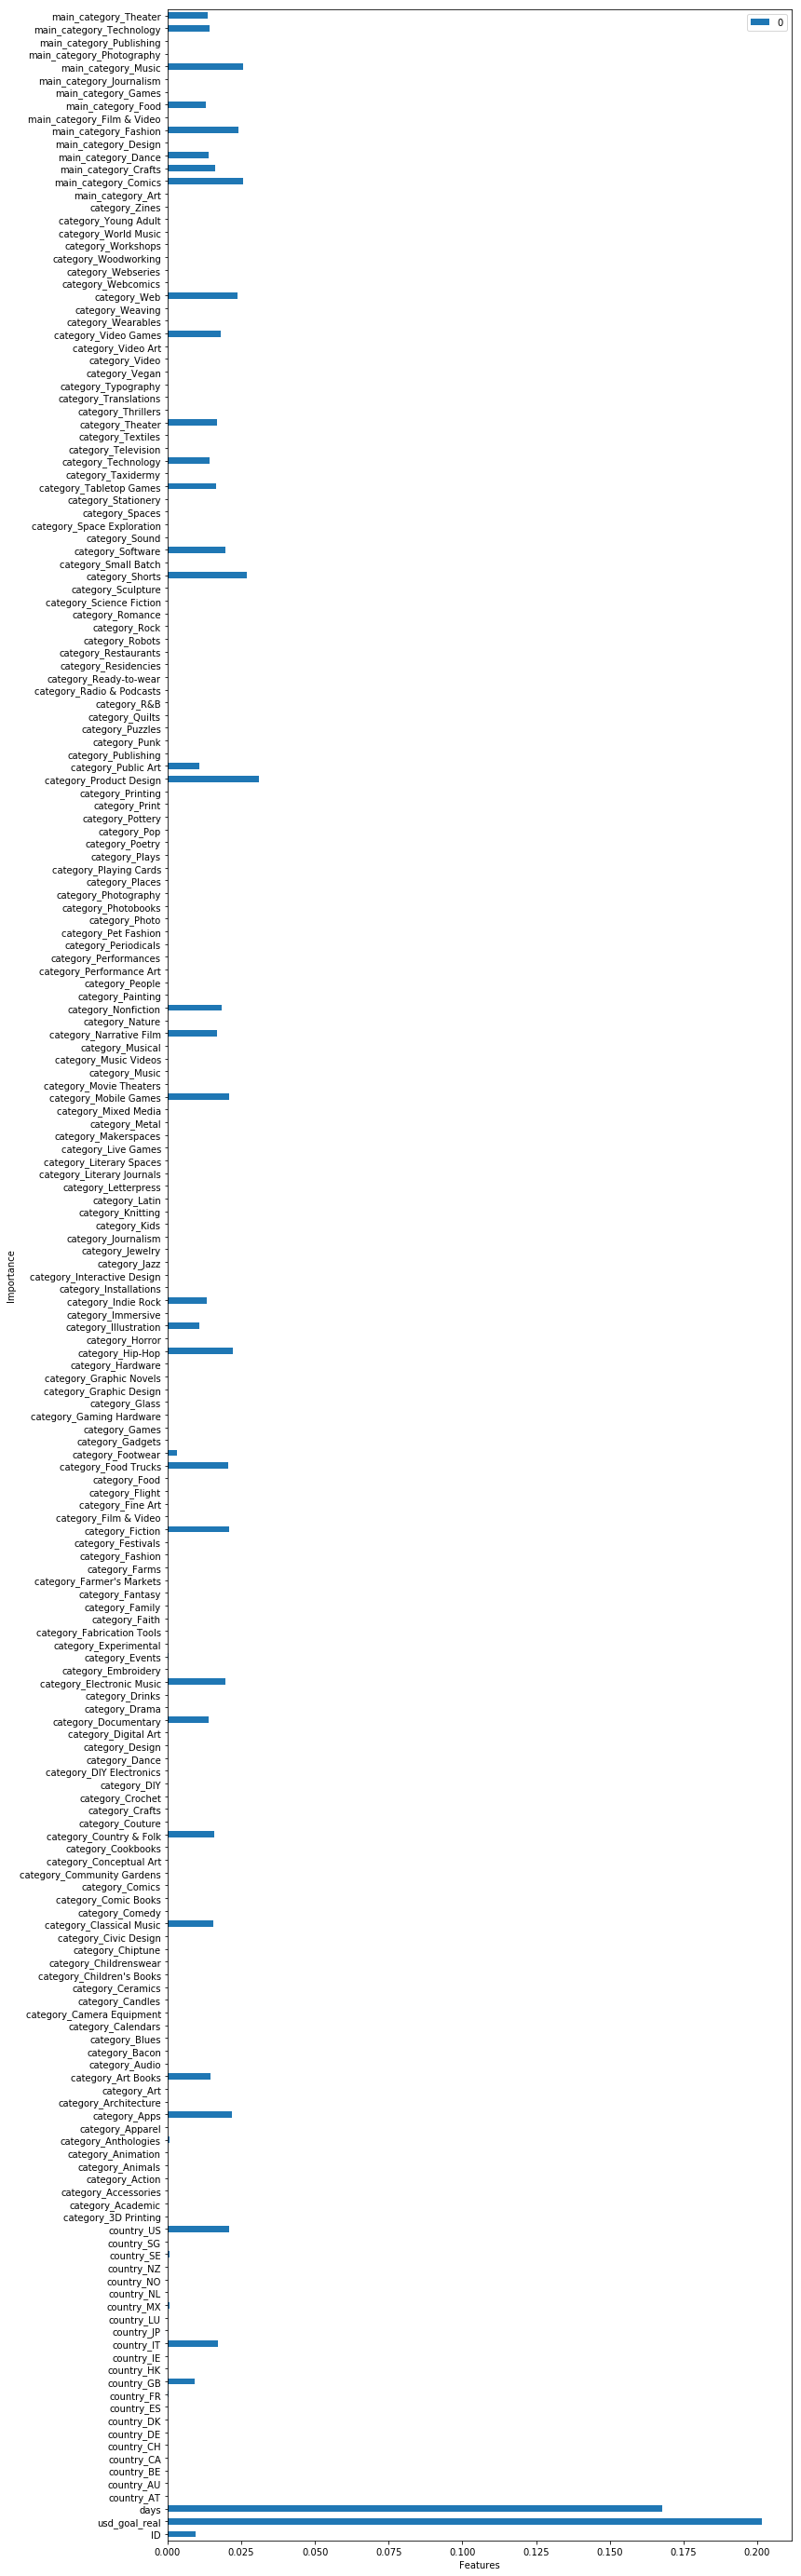

In [50]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=adB_train_data.columns).plot.barh(figsize=(12,50))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

### LassoCVに比べて、特徴量が大幅に削減されている。計算量の観点で、次元が大幅に削減できているので、今回のデータセットではAdaBoostは効率的であった。

### 1.6. できたところまでをNotebookでまとめ、宿題として提出する  

### 1.7. 前回から取り組んだ内容・工夫、精度がどのように変化したかのコメントを Notebookに含めること 

### 1.8. 15分程度，受講者同士で通し課題の進捗を見せ合う時間を設けます